
Failed to download image 1
Failed to download image 2
Failed to download image 3

Creating synthetic stop sign images (offline fallback)...
Created 'synthetic_stop_1.png'
Created 'synthetic_stop_2.png'
Created 'synthetic_stop_3.png'

Running stop sign detection...



100%|██████████| 3/3 [00:00<00:00, 191.38it/s]


Detection results saved to 'detected_stop_signs.csv'
Annotated images saved to 'annotated_images'

Sample detections:


,Filename,X,Y,Width,Height,Timestamp
0,synthetic_stop_1.png,44,44,112,112,2025-08-01 05:28:18
1,synthetic_stop_2.png,44,44,112,112,2025-08-01 05:28:18
2,synthetic_stop_3.png,44,44,112,112,2025-08-01 05:28:18


C:\Users\HP\AppData\Local\Temp\ipykernel_9524\1147507797.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Filename", palette="Set2", legend=False)


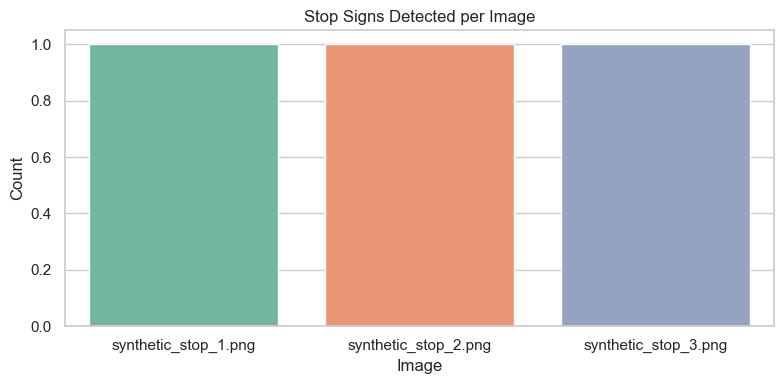

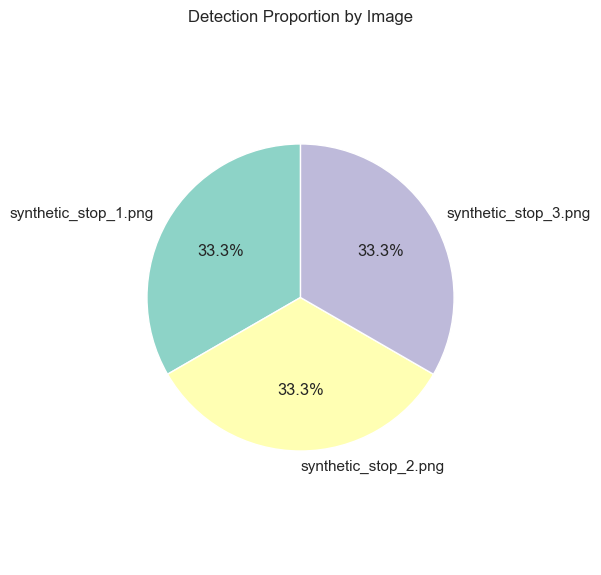

C:\Users\HP\AppData\Local\Temp\ipykernel_9524\1147507797.py:120: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['Minute'] = df["Timestamp"].dt.floor("T")


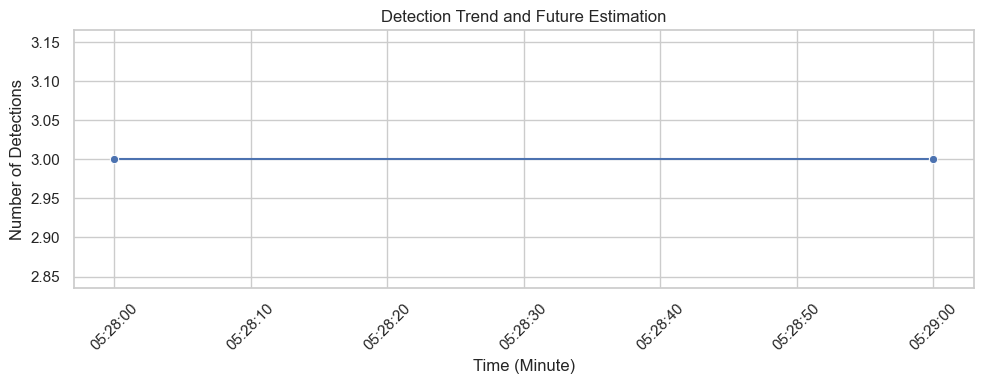

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from PIL import Image, ImageDraw
from IPython.display import display
import requests
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid")

# ------------------ Setup ------------------
IMAGE_DIR = "street_images"
ANNOTATED_DIR = "annotated_images"
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(ANNOTATED_DIR, exist_ok=True)

# ------------------ Download or Create Sample Images ------------------
sample_urls = [
    "https://i.imgur.com/3NCwh2o.jpg",
    "https://i.imgur.com/OQ0dRfV.jpg",
    "https://i.imgur.com/3z0zwVp.jpg"
]

print("Downloading or creating sample stop sign images...\n")
downloaded = False
for i, url in enumerate(sample_urls, 1):
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(f"{IMAGE_DIR}/stop_sign_{i}.jpg", "wb") as f:
                f.write(response.content)
            print(f"Downloaded 'stop_sign_{i}.jpg'")
            downloaded = True
        else:
            print(f"Failed to download image {i}")
    except Exception:
        print(f"Failed to download image {i}")

# ------------------ Fallback: Create Synthetic Images ------------------
if not downloaded:
    print("\nCreating synthetic stop sign images (offline fallback)...")
    for i in range(1, 4):
        img = Image.new("RGB", (200, 200), (255, 255, 255))
        draw = ImageDraw.Draw(img)
        draw.regular_polygon((100, 100, 60), 8, fill=(255, 0, 0))  # Red octagon
        img.save(f"{IMAGE_DIR}/synthetic_stop_{i}.png")
        print(f"Created 'synthetic_stop_{i}.png'")

# ------------------ Detection ------------------
print("\nRunning stop sign detection...\n")
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.png'))]
detections = []

for filename in tqdm(image_files):
    path = os.path.join(IMAGE_DIR, filename)
    img = cv2.imread(path)
    if img is None:
        continue
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Red color mask
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask = cv2.bitwise_or(cv2.inRange(hsv, lower1, upper1), cv2.inRange(hsv, lower2, upper2))

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(cnt)
        if len(approx) == 8 and area > 500:
            x, y, w, h = cv2.boundingRect(approx)
            detections.append({
                "Filename": filename, "X": x, "Y": y,
                "Width": w, "Height": h,
                "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(f"{ANNOTATED_DIR}/{filename}", img)

# ------------------ Save to CSV ------------------
df = pd.DataFrame(detections)
df.to_csv("detected_stop_signs.csv", index=False)
print(f"\nDetection results saved to 'detected_stop_signs.csv'")
print(f"Annotated images saved to '{ANNOTATED_DIR}'")

# ------------------ Display Summary and Charts ------------------
if df.empty:
    print("No stop signs detected.")
else:
    print("\nSample detections:")
    display(df.head())

    # Bar Plot
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x="Filename", palette="Set2", legend=False)
    plt.title("Stop Signs Detected per Image")
    plt.xlabel("Image")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Pie Chart
    pie_data = df["Filename"].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(pie_data, labels=pie_data.index, autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set3"))
    plt.title("Detection Proportion by Image")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    # Line Plot with Future Estimation
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df['Minute'] = df["Timestamp"].dt.floor("T")
    trend = df.groupby("Minute").size().rename("Detections").reset_index()

    # Future projection
    future_time = trend["Minute"].max() + timedelta(minutes=1)
    estimated = trend["Detections"].mean()
    trend = pd.concat([trend, pd.DataFrame({"Minute": [future_time], "Detections": [estimated]})], ignore_index=True)

    plt.figure(figsize=(10, 4))
    sns.lineplot(data=trend, x="Minute", y="Detections", marker="o")
    plt.title("Detection Trend and Future Estimation")
    plt.xlabel("Time (Minute)")
    plt.ylabel("Number of Detections")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


📥 Downloading or creating sample stop sign images...

❌ Failed to download image 1
❌ Failed to download image 2
❌ Failed to download image 3

🧪 Creating synthetic stop sign images (offline fallback)...
✅ Created 'synthetic_stop_1.png'
✅ Created 'synthetic_stop_2.png'
✅ Created 'synthetic_stop_3.png'

🔍 Running stop sign detection...



100%|██████████| 3/3 [00:00<00:00, 216.42it/s]


✅ Detection results saved to 'detected_stop_signs.csv'
🖼 Annotated images saved to 'annotated_images'

📄 Sample detections:


,Filename,X,Y,Width,Height,Timestamp
0,synthetic_stop_1.png,44,44,112,112,2025-08-01 05:28:23
1,synthetic_stop_2.png,44,44,112,112,2025-08-01 05:28:23
2,synthetic_stop_3.png,44,44,112,112,2025-08-01 05:28:23


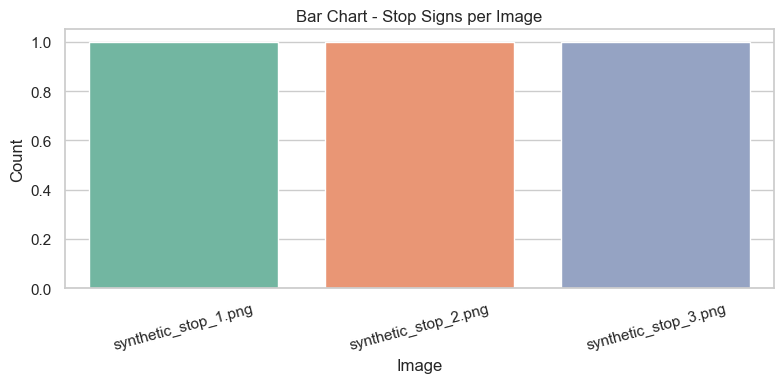

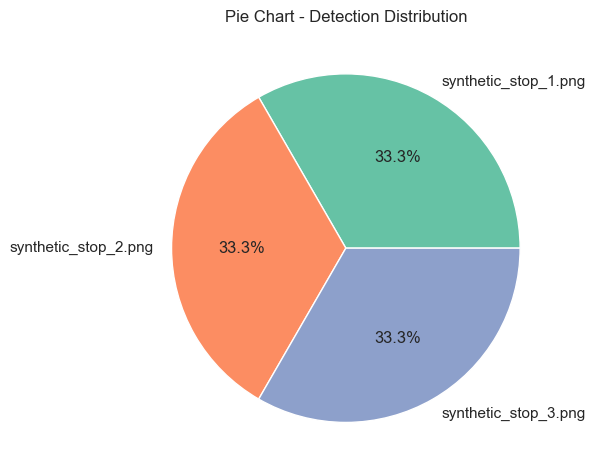

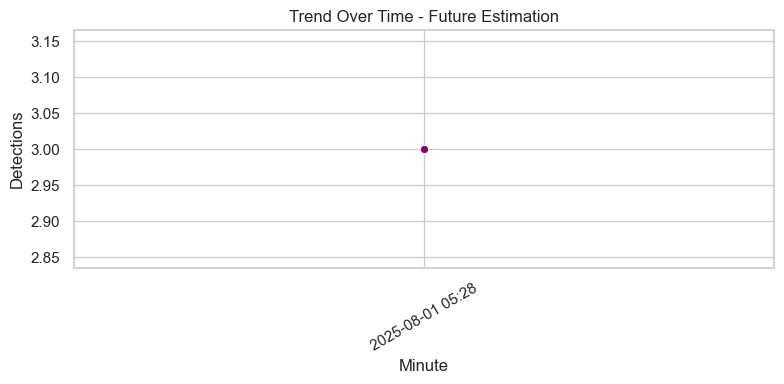

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from PIL import Image, ImageDraw
from IPython.display import display
import requests
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'Arial'

# ------------------ Setup ------------------
IMAGE_DIR = "street_images"
ANNOTATED_DIR = "annotated_images"
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(ANNOTATED_DIR, exist_ok=True)

# ------------------ Download or Create Sample Images ------------------
sample_urls = [
    "https://i.imgur.com/3NCwh2o.jpg",
    "https://i.imgur.com/OQ0dRfV.jpg",
    "https://i.imgur.com/3z0zwVp.jpg"
]

print("📥 Downloading or creating sample stop sign images...\n")
downloaded = False
for i, url in enumerate(sample_urls, 1):
    try:
        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(f"{IMAGE_DIR}/stop_sign_{i}.jpg", "wb") as f:
                f.write(response.content)
            print(f"✅ Downloaded 'stop_sign_{i}.jpg'")
            downloaded = True
        else:
            print(f"❌ Failed to download image {i}")
    except Exception:
        print(f"❌ Failed to download image {i}")

# ------------------ Fallback: Create Synthetic Images ------------------
if not downloaded:
    print("\n🧪 Creating synthetic stop sign images (offline fallback)...")
    for i in range(1, 4):
        img = Image.new("RGB", (200, 200), (255, 255, 255))
        draw = ImageDraw.Draw(img)
        draw.regular_polygon((100, 100, 60), 8, fill=(255, 0, 0))  # Red octagon
        img.save(f"{IMAGE_DIR}/synthetic_stop_{i}.png")
        print(f"✅ Created 'synthetic_stop_{i}.png'")

# ------------------ Detection ------------------
print("\n🔍 Running stop sign detection...\n")
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.png'))]
detections = []

for filename in tqdm(image_files):
    path = os.path.join(IMAGE_DIR, filename)
    img = cv2.imread(path)
    if img is None:
        continue
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Red mask
    lower1, upper1 = np.array([0, 70, 50]), np.array([10, 255, 255])
    lower2, upper2 = np.array([170, 70, 50]), np.array([180, 255, 255])
    mask = cv2.bitwise_or(cv2.inRange(hsv, lower1, upper1), cv2.inRange(hsv, lower2, upper2))

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(cnt)
        if len(approx) == 8 and area > 500:
            x, y, w, h = cv2.boundingRect(approx)
            detections.append({
                "Filename": filename,
                "X": x, "Y": y, "Width": w, "Height": h,
                "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(f"{ANNOTATED_DIR}/{filename}", img)

# ------------------ Save Results ------------------
df = pd.DataFrame(detections)
df.to_csv("detected_stop_signs.csv", index=False)
print(f"\n✅ Detection results saved to 'detected_stop_signs.csv'")
print(f"🖼 Annotated images saved to '{ANNOTATED_DIR}'")

# ------------------ Plots ------------------
if df.empty:
    print("⚠ No stop signs detected.")
else:
    print("\n📄 Sample detections:")
    display(df.head())

    # Bar Chart - Detections per Image
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x="Filename", hue="Filename", palette="Set2", legend=False)
    plt.title("Bar Chart - Stop Signs per Image")
    plt.xlabel("Image")
    plt.ylabel("Count")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    # Pie Chart - Proportion of Detections
    plt.figure(figsize=(6, 6))
    pie_data = df['Filename'].value_counts()
    plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', colors=sns.color_palette("Set2"))
    plt.title("Pie Chart - Detection Distribution")
    plt.tight_layout()
    plt.show()

    # Future Estimation - Detection Trend
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Minute'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M')

    trend = df.groupby("Minute").size().reset_index(name='Detections')
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=trend, x='Minute', y='Detections', marker='o', color='purple')
    plt.title("Trend Over Time - Future Estimation")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
